# Libraries

In [1]:
import tensorflow as tf
from tensorflow.keras import Input
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer, tokenizer_from_json
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, SimpleRNN, GRU, LSTM, Dropout, Masking, Bidirectional, Embedding
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping

import matplotlib.pyplot as plt

import os

import datetime as dt

import seaborn as sns

import pandas as pd

import sklearn 
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import train_test_split

import numpy as np

import pickle

import json

import re

# User-defined functions

In [2]:
def create_model(input_shape=(180), n=128, drop_rate=0.2, n_target=2, embedding_dim=64, vocab_size=10000):
  input_1 = Input(shape=input_shape)

  embedding_1 = Embedding(input_dim=vocab_size, output_dim=embedding_dim)(input_1)
  bi_lstm_1 = Bidirectional(LSTM(embedding_dim, return_sequences=True))(embedding_1)           
  drop_1 = Dropout(drop_rate)(bi_lstm_1)
  lstm_2 = LSTM(n)(drop_1)
  drop_2 = Dropout(drop_rate)(lstm_2)
  dense_1 = Dense(n, activation='relu')(drop_2)
  drop_3 = Dropout(drop_rate)(dense_1)
  
  output_1 = Dense(n_target, activation='softmax')(drop_3)

  return Model(inputs=input_1, outputs=output_1)


def conv(x):
  my_dict = {0: 'negative',
             1: 'positive'}
  
  return my_dict[x]

# Statics

In [3]:
time_stamp = dt.datetime.now().strftime('%Y%m%d-%H%M%S')
LOG_PATH = os.path.join(os.getcwd(), 'logs', time_stamp)

# Load data

In [4]:
DATA_PATH = os.path.join(os.getcwd(), 'data', 'IMDB-Dataset.csv')
df = pd.read_csv(DATA_PATH)
df

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


# General infos

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


# Uniques values of the sentiment

In [6]:
df['sentiment'].unique()

array(['positive', 'negative'], dtype=object)

# Handle duplicates

## view how much duplicates

In [7]:
df.duplicated().sum()

418

## view the duplicates itself

In [8]:
df[df.duplicated()]

,review,sentiment
3537,Quite what the producers of this appalling ada...,negative
3769,My favourite police series of all time turns t...,positive
4391,"Beautiful film, pure Cassavetes style. Gena Ro...",positive
6352,If you liked the Grinch movie... go watch that...,negative
6479,I want very much to believe that the above quo...,negative
...,...,...
49912,This is an incredible piece of drama and power...,positive
49950,This was a very brief episode that appeared in...,negative
49984,Hello it is I Derrick Cannon and I welcome you...,negative
49986,This movie is a disgrace to the Major League F...,negative


## drop/remove duplicates

In [9]:
df = df.drop_duplicates()
df

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


# Wrangle the text review strings

## general look

In [10]:
df['review']

0        One of the other reviewers has mentioned that ...
1        A wonderful little production. <br /><br />The...
2        I thought this was a wonderful way to spend ti...
3        Basically there's a family where a little boy ...
4        Petter Mattei's "Love in the Time of Money" is...
                               ...                        
49995    I thought this movie did a down right good job...
49996    Bad plot, bad dialogue, bad acting, idiotic di...
49997    I am a Catholic taught in parochial elementary...
49998    I'm going to have to disagree with the previou...
49999    No one expects the Star Trek movies to be high...
Name: review, Length: 49582, dtype: object

## remove all HTML tags

In [11]:
df['review'] = df['review'].str.replace('<.*?>', ' ')
df

C:\Users\rhmnnmhmd\AppData\Local\Temp\ipykernel_12616\2787184464.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  df['review'] = df['review'].str.replace('<.*?>', ' ')
C:\Users\rhmnnmhmd\AppData\Local\Temp\ipykernel_12616\2787184464.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['review'] = df['review'].str.replace('<.*?>', ' ')


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. The filming t...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


## remove non-aphabetical characters

In [12]:
df['review'] = df['review'].str.replace('[^a-zA-Z]', ' ')
df

C:\Users\rhmnnmhmd\AppData\Local\Temp\ipykernel_12616\2206521798.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  df['review'] = df['review'].str.replace('[^a-zA-Z]', ' ')
C:\Users\rhmnnmhmd\AppData\Local\Temp\ipykernel_12616\2206521798.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['review'] = df['review'].str.replace('[^a-zA-Z]', ' ')


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production The filming t...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there s a family where a little boy ...,negative
4,Petter Mattei s Love in the Time of Money is...,positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,Bad plot bad dialogue bad acting idiotic di...,negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I m going to have to disagree with the previou...,negative


## lowercase all reviews

In [13]:
df['review'] = df['review'].str.lower()
df

C:\Users\rhmnnmhmd\AppData\Local\Temp\ipykernel_12616\2891927258.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['review'] = df['review'].str.lower()


,review,sentiment
0,one of the other reviewers has mentioned that ...,positive
1,a wonderful little production the filming t...,positive
2,i thought this was a wonderful way to spend ti...,positive
3,basically there s a family where a little boy ...,negative
4,petter mattei s love in the time of money is...,positive
...,...,...
49995,i thought this movie did a down right good job...,positive
49996,bad plot bad dialogue bad acting idiotic di...,negative
49997,i am a catholic taught in parochial elementary...,negative
49998,i m going to have to disagree with the previou...,negative


# Creating and handling the feature input 

In [14]:
reviews = df['review']
reviews

0        one of the other reviewers has mentioned that ...
1        a wonderful little production    the filming t...
2        i thought this was a wonderful way to spend ti...
3        basically there s a family where a little boy ...
4        petter mattei s  love in the time of money  is...
                               ...                        
49995    i thought this movie did a down right good job...
49996    bad plot  bad dialogue  bad acting  idiotic di...
49997    i am a catholic taught in parochial elementary...
49998    i m going to have to disagree with the previou...
49999    no one expects the star trek movies to be high...
Name: review, Length: 49582, dtype: object

## find the number of words in each review

In [15]:
reviews.apply(lambda x: len(x.split()))

0        313
1        160
2        167
3        133
4        228
        ... 
49995    198
49996    111
49997    236
49998    216
49999    127
Name: review, Length: 49582, dtype: int64

## boxplot of the number of words in each review

<AxesSubplot:>

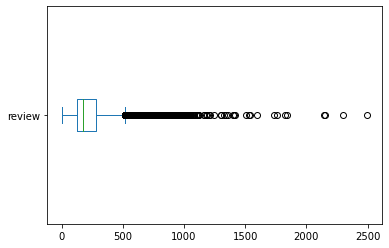

In [16]:
reviews.apply(lambda x: len(x.split())).plot.box(vert=False)

## find the median/mean/mode/max/min number of words in each review

In [26]:
reviews.apply(lambda x: len(x.split())).median()

176.0

In [27]:
reviews.apply(lambda x: len(x.split())).mean()

234.38372796579404

In [28]:
reviews.apply(lambda x: len(x.split())).mode()

0    131
Name: review, dtype: int64

In [29]:
reviews.apply(lambda x: len(x.split())).max()

2494

In [30]:
reviews.apply(lambda x: len(x.split())).min()

6

## tokenizing

In [18]:
vocab_size = 10000
oov_token = '<OOV>'
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_token)
tokenizer.fit_on_texts(reviews)

## show the word index

In [19]:
tokenizer.word_index

{'<OOV>': 1,
 'the': 2,
 'and': 3,
 'a': 4,
 'of': 5,
 'to': 6,
 'is': 7,
 'it': 8,
 'in': 9,
 'i': 10,
 'this': 11,
 'that': 12,
 's': 13,
 'was': 14,
 'as': 15,
 'movie': 16,
 'for': 17,
 'with': 18,
 'but': 19,
 'film': 20,
 'you': 21,
 't': 22,
 'on': 23,
 'not': 24,
 'he': 25,
 'are': 26,
 'his': 27,
 'have': 28,
 'one': 29,
 'be': 30,
 'all': 31,
 'at': 32,
 'they': 33,
 'by': 34,
 'an': 35,
 'who': 36,
 'so': 37,
 'from': 38,
 'like': 39,
 'there': 40,
 'or': 41,
 'just': 42,
 'her': 43,
 'out': 44,
 'about': 45,
 'if': 46,
 'has': 47,
 'what': 48,
 'some': 49,
 'good': 50,
 'can': 51,
 'when': 52,
 'more': 53,
 'very': 54,
 'she': 55,
 'up': 56,
 'no': 57,
 'time': 58,
 'my': 59,
 'even': 60,
 'would': 61,
 'which': 62,
 'only': 63,
 'story': 64,
 'really': 65,
 'see': 66,
 'their': 67,
 'had': 68,
 'me': 69,
 'well': 70,
 'we': 71,
 'were': 72,
 'than': 73,
 'much': 74,
 'bad': 75,
 'get': 76,
 'been': 77,
 'other': 78,
 'do': 79,
 'people': 80,
 'great': 81,
 'will': 82,
 'al

## tokenize the input reviews

In [20]:
reviews_tokenized = tokenizer.texts_to_sequences(reviews)
# len(reviews_tokenized[0])

## padding

In [21]:
# max number of words in each review (usually depends on the median/mean/mode/min/max number of words per review)
max_len = int(reviews.apply(lambda x: len(x.split())).median())
reviews_tokenized_padded = pad_sequences(reviews_tokenized, maxlen=max_len, padding='post', truncating='post')
reviews_tokenized_padded.shape

(49582, 176)

In [22]:
reviews_tokenized_padded

array([[  29,    5,    2, ...,    6,    2,  193],
       [   4,  390,  121, ...,    0,    0,    0],
       [  10,  192,   11, ...,    0,    0,    0],
       ...,
       [  10,  232,    4, ...,    3,    2,   64],
       [  10,  139,  168, ...,   30, 5274,  178],
       [  57,   29, 5822, ...,    0,    0,    0]])

# One-Hot Encoding on target variable

In [23]:
ohe = OneHotEncoder(sparse=False)
sentiment_encoded = ohe.fit_transform(df[['sentiment']])
sentiment_encoded.shape

(49582, 2)

In [24]:
sentiment_encoded

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]])

# Train-test split the data

In [25]:
X_train, X_test, y_train, y_test = train_test_split(reviews_tokenized_padded, sentiment_encoded, test_size=0.2, random_state=123)

# Model creation

## create model

In [26]:
input_shape = reviews_tokenized_padded.shape[-1]
n_target = sentiment_encoded.shape[-1]
embedding_dim = 64

model = create_model(input_shape=(input_shape), 
                     n=128, 
                     drop_rate=0.2, 
                     n_target=n_target, 
                     embedding_dim=embedding_dim, 
                     vocab_size=vocab_size)
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 176)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 176, 64)           640000    
_________________________________________________________________
bidirectional (Bidirectional (None, 176, 128)          66048     
_________________________________________________________________
dropout (Dropout)            (None, 176, 128)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 128)              

## compile model

In [40]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics='acc')

## plot model

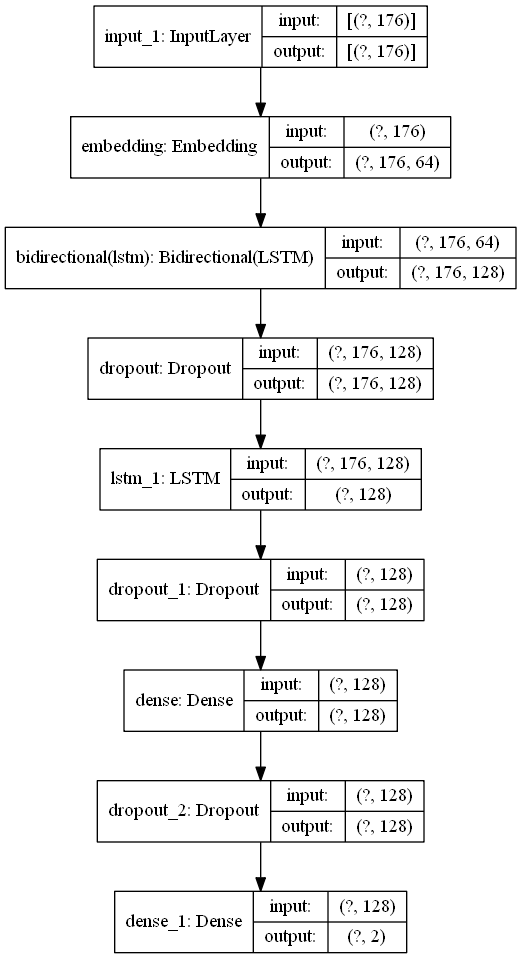

In [28]:
plot_model(model, show_shapes=True, show_layer_names=True)

# Callbacks

In [41]:
tensorboard_callback = TensorBoard(log_dir=LOG_PATH)
early_stopping_callback = EarlyStopping(monitor='loss', 
                                        patience=3, 
                                        verbose=1, 
                                        mode='min')

# Train the model and save the History object

In [ ]:
model_hist = model.fit(X_train, 
                          y_train, 
                          epochs=10,
                          batch_size=128,
                          validation_data=(X_test, y_test),
                          callbacks=[tensorboard_callback, early_stopping_callback])

# Plot loss and metrics

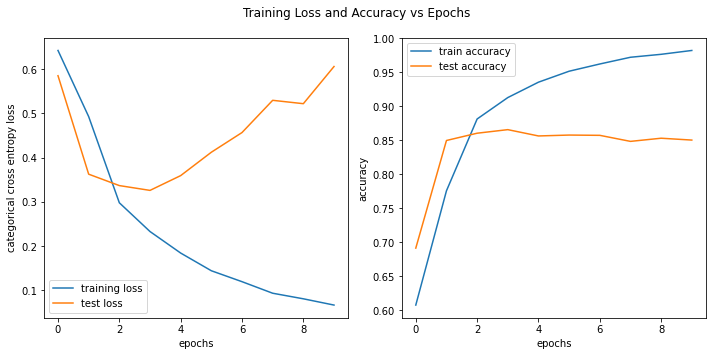

In [53]:
train_loss = model_hist.history['loss']
train_metric = model_hist.history['acc']
test_loss = model_hist.history['val_loss']
test_metric = model_hist.history['val_acc']

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('Training/Test Loss and Metric vs Epochs')

ax[0].plot(train_loss, label='training loss')
ax[0].plot(test_loss, label='test loss')
ax[0].set_xlabel('epochs')
ax[0].set_ylabel('categorical cross entropy loss')
ax[0].legend()

ax[1].plot(train_metric, label='training accuracy')
ax[1].plot(test_metric, label='test accuracy')
ax[1].set_xlabel('epochs')
ax[1].set_ylabel('accuracy')
ax[1].legend()

plt.tight_layout()
plt.show()

# Evaluate on test set

In [80]:
model.evaluate(X_test, y_test)

310/310 [==============================] - 21s 67ms/step - loss: 0.6062 - acc: 0.8504


[0.606227695941925, 0.8503579497337341]

# Predictions

In [81]:
# predict output
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

# vectorize conv(x) function
conv = np.vectorize(conv)

# convert to 'negative' or 'positive'
y_pred_decoded = conv(y_pred).astype(object)
y_pred_decoded

array(['negative', 'negative', 'positive', ..., 'negative', 'negative',
       'negative'], dtype=object)

## decode test set from [0, 1] to ['negative', 'positive']

In [82]:
y_test_decoded = ohe.inverse_transform(y_test)
y_test_decoded = y_test_decoded[:,0]
y_test_decoded

array(['negative', 'negative', 'negative', ..., 'negative', 'positive',
       'positive'], dtype=object)

## classification report

In [83]:
report = classification_report(y_test_decoded, y_pred_decoded)
print(report)

              precision    recall  f1-score   support

    negative       0.84      0.86      0.85      4925
    positive       0.86      0.84      0.85      4992

    accuracy                           0.85      9917
   macro avg       0.85      0.85      0.85      9917
weighted avg       0.85      0.85      0.85      9917



## confusion matrix plot

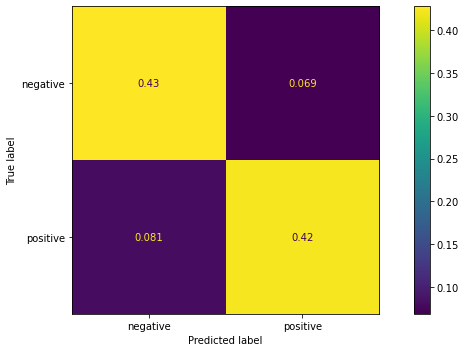

In [84]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ConfusionMatrixDisplay.from_predictions(y_test_decoded, 
                                        y_pred_decoded, 
                                        normalize='all', 
                                        ax=ax)
plt.tight_layout()
plt.show()

# Custom input testing

In [89]:
my_review = input('Give your review: ')

input_review = pd.Series([my_review], name='review')
input_review = input_review.str.replace('<.*?>', ' ')
input_review = input_review.str.replace('[^a-zA-Z]', ' ')
input_review = input_review.str.lower()

input_review_tokenized = tokenizer.texts_to_sequences(input_review)

max_len = int(reviews.apply(lambda x: len(x.split())).median()) # this value is 176 for now
input_review_tokenized_padded = pad_sequences(input_review_tokenized, maxlen=max_len, padding='post', truncating='post')

predicted_sentiment = model.predict(input_review_tokenized_padded)
predicted_sentiment = np.argmax(predicted_sentiment, axis=1)
predicted_sentiment_decoded = conv(predicted_sentiment).astype(object)

print(f'Your review have {predicted_sentiment_decoded[0]} sentiment')

Your review have positive sentiment


C:\Users\rhmnnmhmd\AppData\Local\Temp\ipykernel_13472\1857029586.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  input_review = input_review.str.replace('<.*?>', ' ')
C:\Users\rhmnnmhmd\AppData\Local\Temp\ipykernel_13472\1857029586.py:5: FutureWarning: The default value of regex will change from True to False in a future version.
  input_review = input_review.str.replace('[^a-zA-Z]', ' ')


# Saving objects

## Save the LSTM model

In [ ]:
MODEL_PATH = os.path.join(os.getcwd(), 'model', 'model.h5')
model.save(MODEL_PATH)

## Save tokenizer

In [ ]:
TOKENIZER_PATH = os.path.join(os.getcwd(), 'model', 'tokenizer.pkl')
# tokenizer.to_json(TOKENIZER_PATH)
with open(TOKENIZER_PATH, 'wb') as file:
    pickle.dump(tokenizer, file)   

## Save the One-Hot Encoder

In [ ]:
OHE_PATH = os.path.join(os.getcwd(), 'model', 'ohe.pkl')
with open(OHE_PATH, 'wb') as file:
  pickle.dump(ohe, file)    